In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
!pip install openpyxl
from collections import defaultdict
from matplotlib.colors import TwoSlopeNorm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import random
import matplotlib.patches as mpatches
from matplotlib.cm import get_cmap
import matplotlib.gridspec as gridspec
import seaborn as sns
from matplotlib.colors import LogNorm
from functools import reduce
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
import string

# Reference Dicts

In [2]:
# ─── FIPS mapping ───────────────────────────────────────────────
state_fips_dict = {
    "01": "ALABAMA", "02": "ALASKA", "04": "ARIZONA", "05": "ARKANSAS",
    "06": "CALIFORNIA", "08": "COLORADO", "09": "CONNECTICUT", "10": "DELAWARE",
    "11": "DISTRICT OF COLUMBIA", "12": "FLORIDA", "13": "GEORGIA", "15": "HAWAII",
    "16": "IDAHO", "17": "ILLINOIS", "18": "INDIANA", "19": "IOWA", "20": "KANSAS",
    "21": "KENTUCKY", "22": "LOUISIANA", "23": "MAINE", "24": "MARYLAND",
    "25": "MASSACHUSETTS", "26": "MICHIGAN", "27": "MINNESOTA", "28": "MISSISSIPPI",
    "29": "MISSOURI", "30": "MONTANA", "31": "NEBRASKA", "32": "NEVADA",
    "33": "NEW HAMPSHIRE", "34": "NEW JERSEY", "35": "NEW MEXICO", "36": "NEW YORK",
    "37": "NORTH CAROLINA", "38": "NORTH DAKOTA", "39": "OHIO", "40": "OKLAHOMA",
    "41": "OREGON", "42": "PENNSYLVANIA", "44": "RHODE ISLAND", "45": "SOUTH CAROLINA",
    "46": "SOUTH DAKOTA", "47": "TENNESSEE", "48": "TEXAS", "49": "UTAH",
    "50": "VERMONT", "51": "VIRGINIA", "53": "WASHINGTON", "54": "WEST VIRGINIA",
    "55": "WISCONSIN", "56": "WYOMING"
}

# Abbreviation mapping (if needed)
state_abbrev = {
    '01': 'AL', '02': 'AK', '04': 'AZ', '05': 'AR', '06': 'CA', '08': 'CO',
    '09': 'CT', '10': 'DE', '11': 'DC', '12': 'FL', '13': 'GA', '15': 'HI',
    '16': 'ID', '17': 'IL', '18': 'IN', '19': 'IA', '20': 'KS', '21': 'KY',
    '22': 'LA', '23': 'ME', '24': 'MD', '25': 'MA', '26': 'MI', '27': 'MN',
    '28': 'MS', '29': 'MO', '30': 'MT', '31': 'NE', '32': 'NV', '33': 'NH',
    '34': 'NJ', '35': 'NM', '36': 'NY', '37': 'NC', '38': 'ND', '39': 'OH',
    '40': 'OK', '41': 'OR', '42': 'PA', '44': 'RI', '45': 'SC', '46': 'SD',
    '47': 'TN', '48': 'TX', '49': 'UT', '50': 'VT', '51': 'VA', '53': 'WA',
    '54': 'WV', '55': 'WI', '56': 'WY'
}

In [3]:
nat_MHI_2023 = 82_690

income_df = pd.DataFrame({
    "State": [
        "AL","AK","AZ","AR","CA","CO","CT","DE",
        "DC","FL","GA","HI","ID","IL","IN","IA",
        "KS","KY","LA","ME","MD","MA","MI","MN",
        "MS","MO","MT","NE","NV","NH","NJ","NM",
        "NY","NC","ND","OH","OK","OR","PA","RI",
        "SC","SD","TN","TX","UT","VT","VA","WA",
        "WV","WI","WY"
    ],
    "Median_Income_2023": [
        62248, 88696, 77158, 58748, 95473, 92790, 91477, 81615,
        104643, 73283, 74521, 96716, 74859, 80346, 69458, 71662,
        70316, 61099, 58273, 73463, 98568, 99750, 69097, 85070,
        54386, 68484, 70939, 74727, 76332, 97031, 99716,
        62266, 82052, 70838, 77346, 67873, 62120, 80061,
        73826, 83518, 67988, 72794, 67651, 75778, 93030,
        80626, 89864, 94553, 55875, 74671, 73558
    ]
})

# Parameters

In [4]:
save = False
input_clustering = '_new' # '_new' or ''
optimal_cluster = 'st_cluster_final_gid' # 'st_cluster_final_gid' or 'st_cluster_3_5_7'

test_case = 'random'
premium_type1 = '' # '_Full' '_Discount' or ''
premium_type2 = '' # '_Full'  '_Discount' or ''
premium_type3 = '_Discount' # '_Full'  '_Discount' or ''


base_case1 = '_base_case'
base_case2 = ''
base_case3 = '_base_case'

In [5]:
if test_case == 'historic':
    simulations = 1
else:
    steps = 100
    simulations = 1000

# Data Load

## Simulations

In [6]:
# Simulation data 1
state_balance_df1 = pd.read_csv(f'Results/state_balance_{test_case}{input_clustering}{premium_type1}{base_case1}.csv')
final_balances_df1 = pd.read_csv(f'Results/final_balances_{test_case}{input_clustering}{premium_type1}{base_case1}.csv')
cluster_state_df1 = pd.read_csv(f'Results/cluster_state_{test_case}{input_clustering}{premium_type1}{base_case1}.csv')
balance_transition_df1 = pd.read_csv(f'Results/balance_transition_{test_case}{input_clustering}{premium_type1}{base_case1}.csv')

# Simulation data 2
state_balance_df2 = pd.read_csv(f'Results/state_balance_{test_case}{input_clustering}{premium_type2}{base_case2}.csv')
final_balances_df2 = pd.read_csv(f'Results/final_balances_{test_case}{input_clustering}{premium_type2}{base_case2}.csv')
cluster_state_df2 = pd.read_csv(f'Results/cluster_state_{test_case}{input_clustering}{premium_type2}{base_case2}.csv')
balance_transition_df2 = pd.read_csv(f'Results/balance_transition_{test_case}{input_clustering}{premium_type2}{base_case2}.csv')

# Simulation data 3
state_balance_df3 = pd.read_csv(f'Results/state_balance_{test_case}{input_clustering}{premium_type3}{base_case3}.csv')
final_balances_df3 = pd.read_csv(f'Results/final_balances_{test_case}{input_clustering}{premium_type3}{base_case3}.csv')
cluster_state_df3 = pd.read_csv(f'Results/cluster_state_{test_case}{input_clustering}{premium_type3}{base_case3}.csv')
balance_transition_df3 = pd.read_csv(f'Results/balance_transition_{test_case}{input_clustering}{premium_type3}{base_case3}.csv')

## Risk Policies

In [7]:
# Load risk policies
risk_policies = pd.read_excel('../Local_Data/NFIP_Data/nfip_policy-information-by-state_20240531.xlsx', sheet_name='PIF')

## Premium and Afford Compare

In [8]:
premium_1 = (
    state_balance_df1
    .groupby("STATEFP")["premium"]
    .mean()
    .reset_index(name="premium")
)

premium_2 = (
    state_balance_df2
    .groupby("STATEFP")["premium"]
    .mean()
    .reset_index(name="premium")
)

premium_3 = (
    state_balance_df3
    .groupby("STATEFP")["premium"]
    .mean()
    .reset_index(name="premium")
)

# Merge the two dataframes by STATEFP
premium_compare = premium_3.merge(
    premium_2,
    on="STATEFP",
    suffixes=("_3", "_2")
)

# Compute the difference in the premium column
premium_compare["RR2_increase"] = premium_compare["premium_3"] - premium_compare["premium_2"]

In [9]:
premium_compare["STATEFP"] = (
    premium_compare["STATEFP"]
    .astype(str)
    .str.extract(r"(\d+)", expand=False)
    .str.zfill(2)
)
premium_compare["State"] = premium_compare["STATEFP"].map(state_abbrev)

In [10]:
risk_policies['County'] = risk_policies['County'].str.strip()
risk_policies['State'] = risk_policies['State'].str.strip()

aggregated_risk_policies = risk_policies.groupby(['State']).agg({
    'Policies in Force': 'sum'
}).reset_index()

# Reverse the mapping: State Name → FIPS
state_name_to_fips = {v: k for k, v in state_fips_dict.items()}

# Convert the dictionary to a DataFrame for easy merging
state_df = pd.DataFrame(list(state_fips_dict.items()), columns=['State FIPS', 'State Name'])

aggregated_risk_policies["STATEFP"] = aggregated_risk_policies["State"].map(state_name_to_fips)

premium_compare = premium_compare.merge(income_df, on="State", how="left")

In [11]:
premium_compare = premium_compare.merge(aggregated_risk_policies, on="STATEFP", how="left").rename(columns={
    "State_x": "State_Abbr",
    "State_y": "State"
})

In [12]:
premium_compare['RR2_afford'] = premium_compare['premium_3']/premium_compare['Median_Income_2023']/premium_compare['Policies in Force']*100

premium_compare['base_afford'] = premium_compare['premium_2']/premium_compare['Median_Income_2023']/premium_compare['Policies in Force']*100

## Extreme Loss vs Underpricing Risk

In [13]:
# ── Step 2: Group by STATEFP and calculate averages ──
def average_ratio(df, flag_col, flag_val, label):
    return (
        df[df[flag_col] == flag_val]
        .groupby("STATEFP")["contribution_ratio"]
        .mean()
        .reset_index()
        .rename(columns={"contribution_ratio": label})
    )

In [14]:
# ── Step 1: Create category flags ──
state_balance_df1["is_positive"] = state_balance_df1["contribution"] > 0
state_balance_df1["is_negative"] = state_balance_df1["contribution"] < 0
state_balance_df1["contribution_ratio"] = state_balance_df1["contribution"] / state_balance_df1["premium"]
state_balance_df1.replace([np.inf, -np.inf], np.nan, inplace=True)

avg_positive1 = average_ratio(state_balance_df1, "is_positive", True, "Avg_Pos")
avg_negative1 = average_ratio(state_balance_df1, "is_negative", True, "Avg_Neg")

state_balance_df2["is_positive"] = state_balance_df2["contribution"] > 0
state_balance_df2["is_negative"] = state_balance_df2["contribution"] < 0
state_balance_df2["contribution_ratio"] = state_balance_df2["contribution"] / state_balance_df2["premium"]
state_balance_df2.replace([np.inf, -np.inf], np.nan, inplace=True)

avg_positive2 = average_ratio(state_balance_df2, "is_positive", True, "Avg_Pos")
avg_negative2 = average_ratio(state_balance_df2, "is_negative", True, "Avg_Neg")

# ── Step 1: Create category flags ──
state_balance_df3["is_positive"] = state_balance_df3["contribution"] > 0
state_balance_df3["is_negative"] = state_balance_df3["contribution"] < 0
state_balance_df3["contribution_ratio"] = state_balance_df3["contribution"] / state_balance_df3["premium"]
state_balance_df3.replace([np.inf, -np.inf], np.nan, inplace=True)

avg_positive3 = average_ratio(state_balance_df3, "is_positive", True, "Avg_Pos")
avg_negative3 = average_ratio(state_balance_df3, "is_negative", True, "Avg_Neg")

In [15]:
# 1) Normalize key dtype (strings like "01")
premium_compare["STATEFP"] = premium_compare["STATEFP"].astype(str).str.zfill(2)

for df_name in ["avg_positive1","avg_negative1","avg_positive2","avg_negative2","avg_positive3","avg_negative3"]:
    df = locals()[df_name]
    if "STATEFP" not in df.columns:  # handle Series/index cases
        df = df.reset_index()
    df["STATEFP"] = df["STATEFP"].astype(str).str.zfill(2)
    locals()[df_name] = df  # put back


# Rename columns for clarity
avg_positive1 = avg_positive1.rename(columns={"Avg_Pos": "Avg_Pos_1"})
avg_negative1 = avg_negative1.rename(columns={"Avg_Neg": "Avg_Neg_1"})

avg_positive2 = avg_positive2.rename(columns={"Avg_Pos": "Avg_Pos_2"})
avg_negative2 = avg_negative2.rename(columns={"Avg_Neg": "Avg_Neg_2"})

avg_positive3 = avg_positive3.rename(columns={"Avg_Pos": "Avg_Pos_3"})
avg_negative3 = avg_negative3.rename(columns={"Avg_Neg": "Avg_Neg_3"})

# Merge them all onto premium_compare
premium_compare = (
    premium_compare
    .merge(avg_positive1[["STATEFP", "Avg_Pos_1"]], on="STATEFP", how="left")
    .merge(avg_negative1[["STATEFP", "Avg_Neg_1"]], on="STATEFP", how="left")
    .merge(avg_positive2[["STATEFP", "Avg_Pos_2"]], on="STATEFP", how="left")
    .merge(avg_negative2[["STATEFP", "Avg_Neg_2"]], on="STATEFP", how="left")
    .merge(avg_positive3[["STATEFP", "Avg_Pos_3"]], on="STATEFP", how="left")
    .merge(avg_negative3[["STATEFP", "Avg_Neg_3"]], on="STATEFP", how="left")
)


## Geospatial

In [16]:
# Geospatial data
# Load the shapefile for US counties
shapefile_path = '../Local_Data/Geospatial/tl_2019_us_county.shp'
gdf_counties = gpd.read_file(shapefile_path)

# Load the shapefile for US states
state_shapefile_path = '../Local_Data/Geospatial/cb_2018_us_state_20m.shp'
gdf_states = gpd.read_file(state_shapefile_path)
gdf_states["STATEFP"] = pd.to_numeric(gdf_states["STATEFP"], errors="coerce").astype("Int64")

# Plotting

## National Pool

In [17]:
# --- Summary per simulation ---
# Canonical list of simulations present
sim_index = pd.Index(sorted(final_balances_df1['simulation'].unique()), name='simulation')

# --- Pooled (cumulative) balance per simulation over years ---
time_series_df = (
    state_balance_df1
    .groupby(['simulation', 'year'], as_index=False)['nfip_balance'].sum()
    .rename(columns={'nfip_balance': 'total_balance'})
)

# ─────────────────────────────
# Compute stats across simulations
# ─────────────────────────────
stats_by_year = (
    time_series_df
    .groupby('year')['total_balance']
    .agg(
        min='min',
        max='max',
        mean='mean',
        q25=lambda x: x.quantile(0.25),
        q75=lambda x: x.quantile(0.75)
    )
    .reset_index()
    .sort_values('year')
)

In [18]:
# Sum contributions and balances across states per year + simulation
federal_df = (
    state_balance_df1
    .groupby(['simulation', 'year'], as_index=False)
    .agg({'contribution': 'sum', 'nfip_balance': 'sum'})
)

# Apply national logic
def pooled_drawdown(row):
    contrib, bal = row['contribution'], row['nfip_balance']
    if contrib >= 0:
        return 0
    elif bal >= 0:
        return abs(min(0, bal + contrib))
    else:
        return abs(contrib)

federal_df['reins_need'] = federal_df.apply(pooled_drawdown, axis=1)

# Sum across time to get total reinsurance need per simulation
reins_need = (
    federal_df.groupby('simulation')['reins_need']
    .sum()
    .reindex(sim_index, fill_value=0)
)

# Apply logic at the state level
def state_drawdown(row):
    contrib, bal = row['contribution'], row['nfip_balance']
    if contrib >= 0:
        return 0
    elif bal >= 0:
        return abs(min(0, bal + contrib))
    else:
        return abs(contrib)

state_balance_df1['neg_draw'] = state_balance_df1.apply(state_drawdown, axis=1)
state_balance_df2['neg_draw'] = state_balance_df2.apply(state_drawdown, axis=1)
state_balance_df3['neg_draw'] = state_balance_df3.apply(state_drawdown, axis=1)


# Then sum by simulation and state, then across states
total_neg = (
    state_balance_df1
    .groupby(['simulation', 'STATEFP'])['neg_draw']
    .sum()
    .groupby('simulation')
    .sum()
    .reindex(sim_index, fill_value=0)
)

summary = pd.DataFrame({
    'simulation': sim_index,
    'Total_Reinsurance_Used': reins_need.values,  # Federal pooled
    'Total_Negative_Balance': total_neg.values    # State unpooled
})

# Averages across simulations for the bar chart
avg_reinsurance_used = summary['Total_Reinsurance_Used'].mean()
avg_negative_balance = summary['Total_Negative_Balance'].abs().mean()

/tmp/ipykernel_2438/1043669067.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


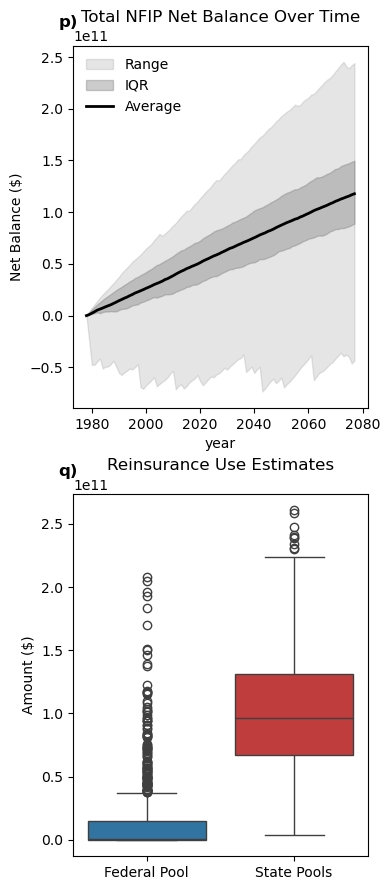

In [19]:
# ─────────────────────────────
# Prepare data for boxplot
# ─────────────────────────────
# Stack simulation outcomes for each metric
bar_df = summary[['Total_Reinsurance_Used', 'Total_Negative_Balance']].copy()
bar_df = bar_df.rename(columns={
    'Total_Reinsurance_Used': 'Federal Pool',
    'Total_Negative_Balance': 'State Pools'
})

# Melt into long format
bar_long = bar_df.melt(var_name="Pool", value_name="Amount")

# ─────────────────────────────
# Plotting
# ─────────────────────────────
fig, axs = plt.subplots(2, 1, figsize=(4, 9), sharex=False)
panel_labels = ['p)', 'q)']
label_offset = (-0.05, 1.05)

# --- Panel p: Time Series with min–max shading and mean line ---
ax = axs[0]
ax.fill_between(
    stats_by_year['year'],
    stats_by_year['min'],
    stats_by_year['max'],
    alpha=0.2,
    color='gray',
    label='Range'
)

ax.fill_between(
    stats_by_year['year'],
    stats_by_year['q25'],
    stats_by_year['q75'],
    alpha=0.4,
    color='gray',
    label='IQR'
)

sns.lineplot(
    data=stats_by_year, x='year', y='mean',
    ax=ax, color='black', lw=2, label='Average'
)
ax.set_title("Total NFIP Net Balance Over Time")
ax.set_ylabel("Net Balance ($)")
ax.text(label_offset[0], label_offset[1], panel_labels[0], transform=ax.transAxes,
        fontsize=12, fontweight='bold')
ax.legend(frameon=False)

# --- Panel q: Boxplots across simulations ---
sns.boxplot(
    data=bar_long,
    x="Pool", y="Amount",
    ax=axs[1],
    palette={"Federal Pool": "tab:blue", "State Pools": "tab:red"}
)

axs[1].set_title("Reinsurance Use Estimates")
axs[1].set_ylabel("Amount ($)")
axs[1].set_xlabel("")

axs[1].text(label_offset[0], label_offset[1], panel_labels[1], transform=axs[1].transAxes,
            fontsize=12, fontweight='bold')

plt.tight_layout()
if save:
    plt.savefig(f"Plots/New/NFIP_Summary_Facets_{test_case}.png", dpi=500, bbox_inches='tight')
plt.show()

## Timeseries of State Pools

In [20]:
# Selected state abbreviations
selected_states = ['LA', 'MS', 'AL', 'TX', 'NY', 'NJ']

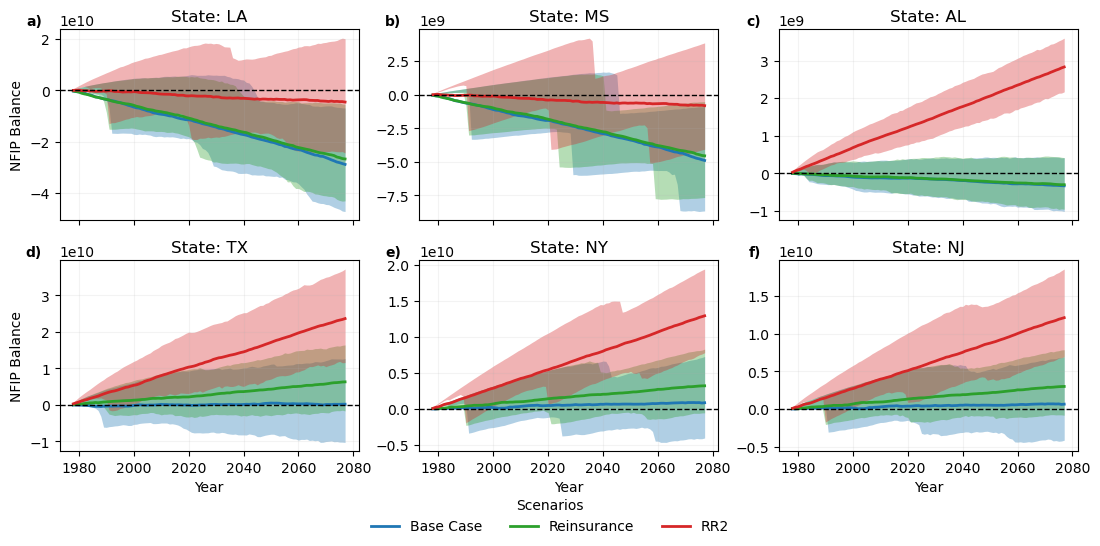

In [21]:
# ──────────────────────────────────────────────────────────────────────────────
# CONFIG: tweak these names and colors as you like
# ──────────────────────────────────────────────────────────────────────────────
scenario_dfs = {
    "Base Case": state_balance_df1,
    "Reinsurance": state_balance_df2,
    "RR2": state_balance_df3,
}

scenario_colors = {
    "Base Case": "#1f77b4",  # blue
    "Reinsurance": "#2ca02c",  # green
    "RR2": "#d62728",  # red
}

# Band/line styling
RANGE_ALPHA = 0.15   # light band: min–max
IQR_ALPHA   = 0.35   # darker band: 25–75%
MEAN_LW     = 2.0

# ──────────────────────────────────────────────────────────────────────────────
# Helpers
# ──────────────────────────────────────────────────────────────────────────────
def prep_state_stats(df, selected_states, state_abbrev):
    """
    Normalize STATEFP, compute cumulative balances per simulation/state, map to abbreviations,
    filter selected states, and aggregate stats across simulations by (State, year).
    Returns a DataFrame with columns: State, year, min, max, mean, q25, q75
    """
    df = df.copy()

    # Normalize STATEFP to zero-padded 2-char strings
    df["STATEFP"] = (
        df["STATEFP"]
        .astype(str)
        .str.extract(r"(\d+)", expand=False)
        .str.zfill(2)
    )

    # cumulative balance per simulation & state
    df["cumulative_balance"] = (
        df.groupby(["simulation", "STATEFP"])["contribution"]
          .cumsum()
    )

    # Add abbreviation and filter
    df["State"] = df["STATEFP"].map(state_abbrev)
    df = df[df["State"].isin(selected_states)].copy()

    # Aggregate across simulations: min, max, mean, IQR
    stats = (
        df.groupby(["State", "year"])["cumulative_balance"]
          .agg(
              min="min",
              max="max",
              mean="mean",
              q25=lambda x: x.quantile(0.25),
              q75=lambda x: x.quantile(0.75),
          )
          .reset_index()
    )

    # Sort for clean plotting
    stats = stats.sort_values(["State", "year"])
    return stats

# ──────────────────────────────────────────────────────────────────────────────
# Compute stats for each scenario
# ──────────────────────────────────────────────────────────────────────────────
stats_by_scenario = {
    scen_name: prep_state_stats(df, selected_states, state_abbrev)
    for scen_name, df in scenario_dfs.items()
}

# ──────────────────────────────────────────────────────────────────────────────
# Plotting
# ──────────────────────────────────────────────────────────────────────────────
n_states = len(selected_states)
n_cols   = 3
n_rows   = -(-n_states // n_cols)  # ceiling division

fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(11, 2.8 * n_rows), sharex=True, sharey=False
)
axes = np.atleast_1d(axes).flatten()

for i, state in enumerate(selected_states):
    ax = axes[i]

    # Plot each scenario on the same subplot
    for scen_name, stats in stats_by_scenario.items():
        color = scenario_colors.get(scen_name, "C0")
        df_sub = stats[stats["State"] == state].sort_values("year")

        if df_sub.empty:
            continue

        years = df_sub["year"].values

        # Darker shading for IQR (25–75th percentiles)
        ax.fill_between(
            years, df_sub["q25"], df_sub["q75"],
            color=color, alpha=IQR_ALPHA, linewidth=0
        )

        # Mean line
        ax.plot(
            years, df_sub["mean"],
            color=color, linewidth=MEAN_LW, label=scen_name
        )

    # Zero line
    ax.axhline(0, color='black', linestyle='--', linewidth=1)

    ax.set_title(f"State: {state}")
    ax.grid(True, alpha=0.15)

    # Subpanel label
    panel_label = f"{chr(97 + i)})"
    ax.text(-0.06, 1.08, panel_label,
            transform=ax.transAxes,
            fontsize=10, fontweight='bold',
            va='top', ha='right')

    row_idx = i // n_cols
    col_idx = i % n_cols
    ax.set_xlabel("Year" if row_idx == n_rows - 1 else "")
    ax.set_ylabel("NFIP Balance" if col_idx == 0 else "")

# Hide unused axes if any
for j in range(i + 1, n_rows * n_cols):
    axes[j].axis("off")

# Build a clean shared legend: just the scenario lines
# (Bands are the IQR (darker) and Min–Max (lighter) for each scenario.)
handles, labels = [], []
for scen_name, color in scenario_colors.items():
    ln, = plt.plot([], [], color=color, lw=MEAN_LW, label=scen_name)
    handles.append(ln)
    labels.append(scen_name)

leg = fig.legend(
    handles, labels, loc="lower center", ncol=min(3, len(labels)), frameon=False
)
leg.set_title("Scenarios")

plt.subplots_adjust(hspace=0.55, wspace=0.25)
plt.tight_layout(rect=[0, 0.06, 1, 0.98])  # leave room at bottom for legend

if save:
    plt.savefig(f"Plots/New/Balance_Timeseries_{test_case}.png", dpi=500, bbox_inches='tight')

plt.show()

## Cost for changes

In [22]:
reinsurance_costs = 88.43/3 + 50.37/3 + 61.23/3 + 121.1

RR2_costs = premium_compare[premium_compare["State_Abbr"].isin(selected_states)].copy()

RR2_costs['rein_increase'] = reinsurance_costs*RR2_costs['Policies in Force']/np.sum(RR2_costs['Policies in Force'])

RR2_costs['RR2_increase'] = RR2_costs['RR2_increase']/1_000_000

RR2_costs['rein_afford'] = (RR2_costs['premium_2'] + RR2_costs['rein_increase']*1_000_000)/premium_compare['Median_Income_2023']/premium_compare['Policies in Force']*100

In [23]:
RR2_costs

,STATEFP,premium_3,premium_2,RR2_increase,State_Abbr,Median_Income_2023,State,Policies in Force,RR2_afford,base_afford,Avg_Pos_1,Avg_Neg_1,Avg_Pos_2,Avg_Neg_2,Avg_Pos_3,Avg_Neg_3,rein_increase,rein_afford
0,01,7.033941e+07,37800028.0,32.539385,AL,62248.0,ALABAMA,47805.0,2.363742,1.270262,0.797323,-5.272753,0.799121,-5.132273,0.873626,-2.807837,5.702575,1.461896
16,22,6.588057e+08,376505347.0,282.300387,LA,58273.0,LOUISIANA,446614.0,2.531382,1.446677,0.794454,-9.650856,0.795893,-9.349299,0.852322,-7.703471,53.275809,1.651382
22,28,1.005608e+08,52457678.0,48.103079,MS,54386.0,MISSISSIPPI,53898.0,3.430590,1.789572,0.746595,-12.512226,0.750209,-12.025412,0.826102,-13.189890,6.429399,2.008909
28,34,3.068373e+08,192796546.0,114.040737,NJ,99716.0,NEW JERSEY,203643.0,1.511032,0.949434,0.883402,-5.720204,0.882537,-4.752082,0.892526,-5.029627,24.292220,1.069062
30,36,2.991687e+08,179100275.0,120.068467,NY,82052.0,NEW YORK,167581.0,2.175716,1.302514,0.825445,-11.191473,0.824180,-9.275638,0.881144,-9.616826,19.990447,1.447895
41,48,7.663699e+08,527237999.0,239.131950,TX,75778.0,TEXAS,654601.0,1.544965,1.062887,0.784213,-4.393207,0.785005,-3.751441,0.830057,-3.228018,78.086217,1.220305


### Cost Compare

/tmp/ipykernel_2438/3834237394.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2438/3834237394.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="")


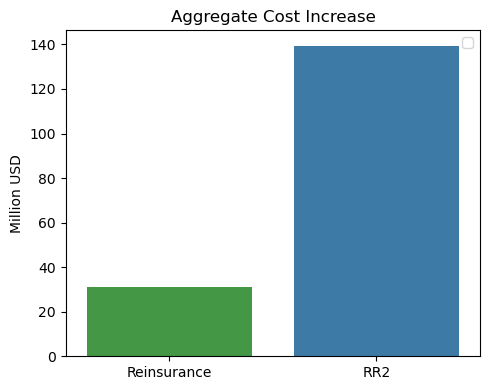

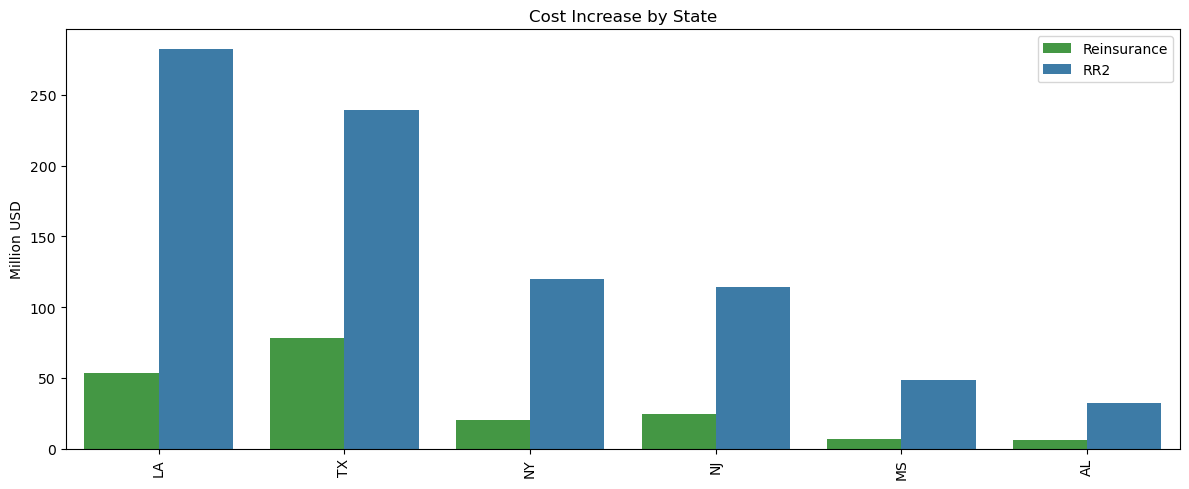

/tmp/ipykernel_2438/3834237394.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2438/3834237394.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="")


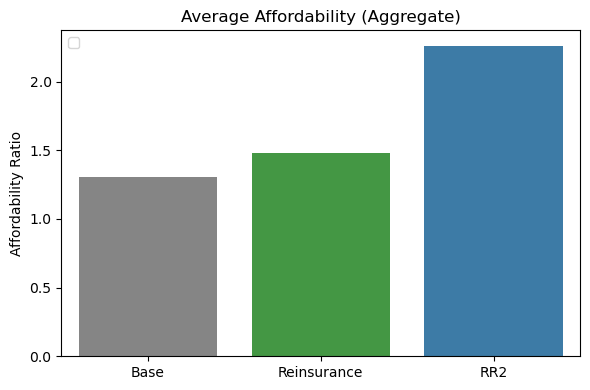

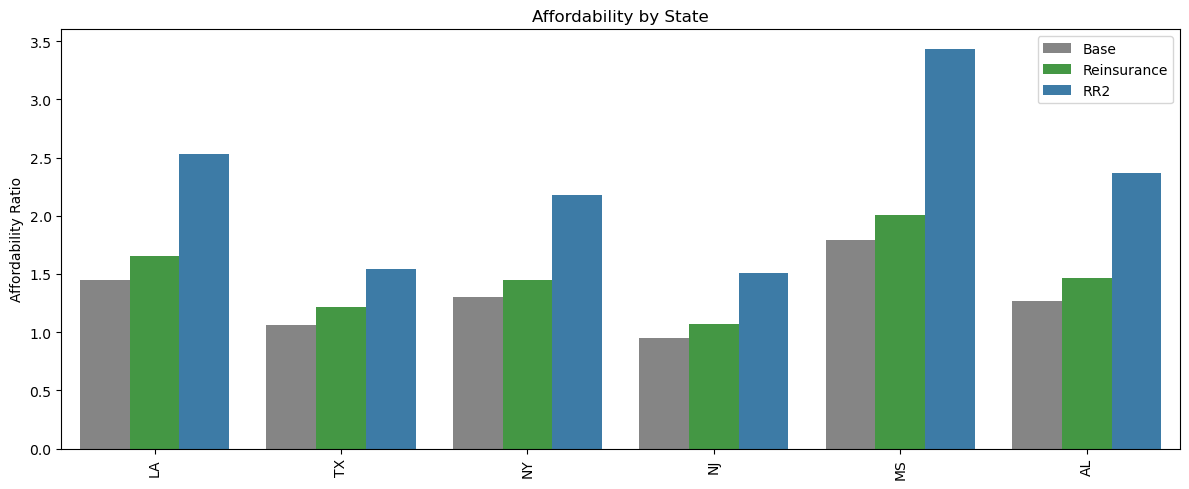

/tmp/ipykernel_2438/3834237394.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2438/3834237394.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="")


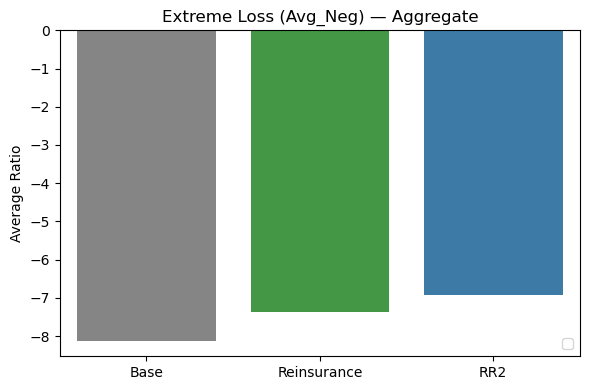

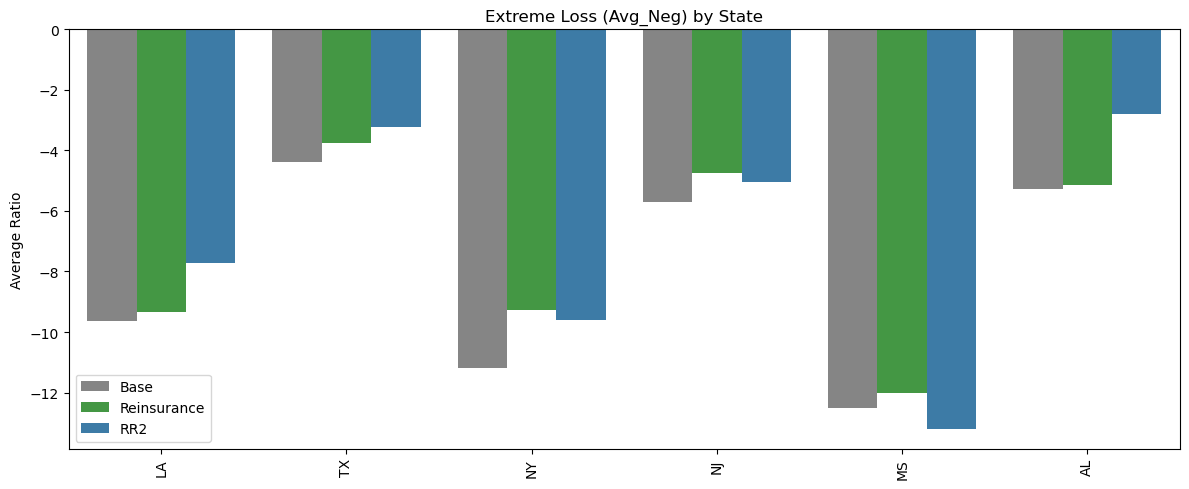

/tmp/ipykernel_2438/3834237394.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
/tmp/ipykernel_2438/3834237394.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title="")


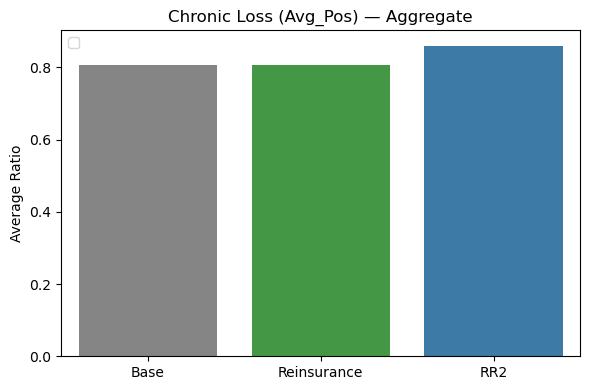

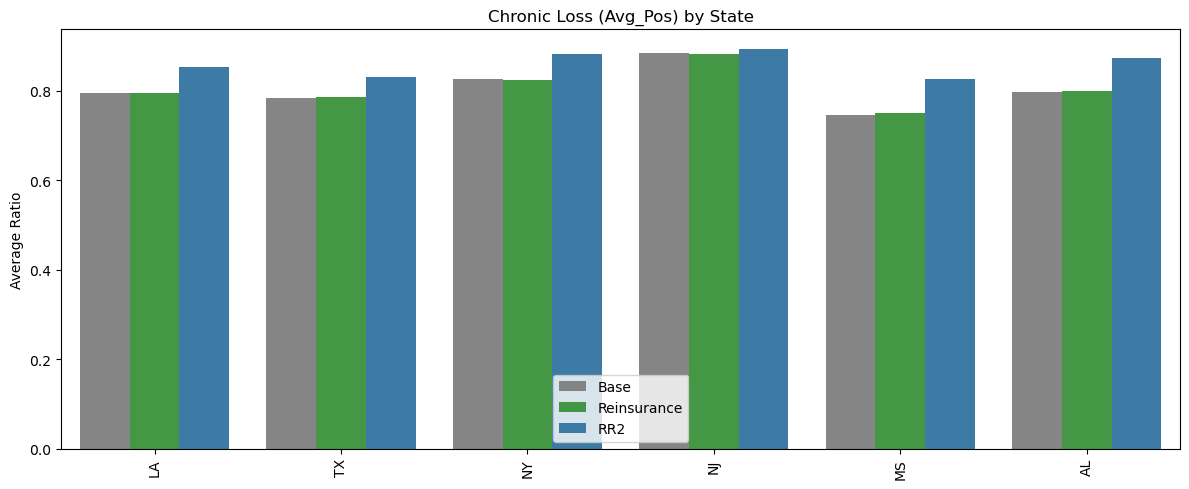

In [24]:
# Use your dataframe
df = RR2_costs.copy()

# --------------------------
# Config (easy color control)
# --------------------------
PALETTE = {
    "RR2": "#1f77b4",
    "Reinsurance": "#2ca02c",
    "Base": "#7f7f7f",
}
BAR_ALPHA = 0.95

df = RR2_costs.copy()

# Units: make sure cost columns are in millions
for col in ["RR2_increase", "rein_increase"]:
    if df[col].abs().max() > 1e5:  # likely raw dollars, not millions
        df[col] = df[col] / 1e6

# consistent order for states (sort by RR2 cost increase descending for visibility)
state_order = df.sort_values("RR2_increase", ascending=False)["State_Abbr"].tolist()

# Small helper: grouped bar chart from a tidy (melted) df
def grouped_bar(tidy_df, x, y, hue, title, ylabel, order=None, hue_order=None, rotate_xticks=True, height=4, width=10):
    plt.figure(figsize=(width, height))
    ax = sns.barplot(
        data=tidy_df,
        x=x, y=y, hue=hue,
        order=order, hue_order=hue_order,
        palette=PALETTE, alpha=BAR_ALPHA
    )
    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("")
    if rotate_xticks:
        plt.xticks(rotation=90)
    ax.legend(title="")
    plt.tight_layout()
    plt.show()

# --------------------------
# 1) COST COMPARISONS
# --------------------------
# Aggregate (means across states)
cost_agg = pd.DataFrame({
    "Scenario": ["Reinsurance", "RR2"],
    "Cost Increase (Million USD)": [
        df["rein_increase"].mean(),
        df["RR2_increase"].mean()
    ]
})
grouped_bar(
    cost_agg.rename(columns={"Scenario":"Scenario", "Cost Increase (Million USD)":"Value"}),
    x="Scenario", y="Value", hue=None, title="Aggregate Cost Increase", ylabel="Million USD",
    order=["Reinsurance", "RR2"], hue_order=None, rotate_xticks=False, height=4, width=5
)

# By state (two bars per state)
cost_state = (
    df[["State_Abbr", "rein_increase", "RR2_increase"]]
      .melt(id_vars="State_Abbr", var_name="Scenario", value_name="Value")
      .replace({"rein_increase":"Reinsurance", "RR2_increase":"RR2"})
)
grouped_bar(
    cost_state, x="State_Abbr", y="Value", hue="Scenario",
    title="Cost Increase by State", ylabel="Million USD",
    order=state_order, hue_order=["Reinsurance", "RR2"], height=5, width=12
)

# --------------------------
# 2) AFFORDABILITY
# --------------------------
# Aggregate
aff_agg = pd.DataFrame({
    "Scenario": ["Base", "Reinsurance", "RR2"],
    "Affordability": [
        df["base_afford"].mean(),
        df["rein_afford"].mean(),
        df["RR2_afford"].mean()
    ]
})
grouped_bar(
    aff_agg.rename(columns={"Affordability":"Value"}),
    x="Scenario", y="Value", hue=None, title="Average Affordability (Aggregate)", ylabel="Affordability Ratio",
    order=["Base", "Reinsurance", "RR2"], rotate_xticks=False, height=4, width=6
)

# By state (three bars per state)
aff_state = (
    df[["State_Abbr","base_afford","rein_afford","RR2_afford"]]
      .melt(id_vars="State_Abbr", var_name="Scenario", value_name="Value")
      .replace({"base_afford":"Base","rein_afford":"Reinsurance","RR2_afford":"RR2"})
)
grouped_bar(
    aff_state, x="State_Abbr", y="Value", hue="Scenario",
    title="Affordability by State", ylabel="Affordability Ratio",
    order=state_order, hue_order=["Base","Reinsurance","RR2"], height=5, width=12
)

# --------------------------
# 3) LOSS RATIOS
# NOTE (corrected mapping):
# Avg_Neg = Extreme Loss; Avg_Pos = Chronic Loss
# --------------------------
# Aggregate — Extreme (Avg_Neg)
extreme_agg = pd.DataFrame({
    "Scenario": ["Base","Reinsurance","RR2"],
    "Value": [
        df["Avg_Neg_1"].mean(),
        df["Avg_Neg_2"].mean(),
        df["Avg_Neg_3"].mean()
    ]
})
grouped_bar(
    extreme_agg, x="Scenario", y="Value", hue=None,
    title="Extreme Loss (Avg_Neg) — Aggregate", ylabel="Average Ratio",
    order=["Base","Reinsurance","RR2"], rotate_xticks=False, height=4, width=6
)

# By state — Extreme (Avg_Neg)
extreme_state = (
    df[["State_Abbr","Avg_Neg_1","Avg_Neg_2","Avg_Neg_3"]]
      .rename(columns={"Avg_Neg_1":"Base","Avg_Neg_2":"Reinsurance","Avg_Neg_3":"RR2"})
      .melt(id_vars="State_Abbr", var_name="Scenario", value_name="Value")
)
grouped_bar(
    extreme_state, x="State_Abbr", y="Value", hue="Scenario",
    title="Extreme Loss (Avg_Neg) by State", ylabel="Average Ratio",
    order=state_order, hue_order=["Base","Reinsurance","RR2"], height=5, width=12
)

# Aggregate — Chronic (Avg_Pos)
chronic_agg = pd.DataFrame({
    "Scenario": ["Base","Reinsurance","RR2"],
    "Value": [
        df["Avg_Pos_1"].mean(),
        df["Avg_Pos_2"].mean(),
        df["Avg_Pos_3"].mean()
    ]
})
grouped_bar(
    chronic_agg, x="Scenario", y="Value", hue=None,
    title="Chronic Loss (Avg_Pos) — Aggregate", ylabel="Average Ratio",
    order=["Base","Reinsurance","RR2"], rotate_xticks=False, height=4, width=6
)

# By state — Chronic (Avg_Pos)
chronic_state = (
    df[["State_Abbr","Avg_Pos_1","Avg_Pos_2","Avg_Pos_3"]]
      .rename(columns={"Avg_Pos_1":"Base","Avg_Pos_2":"Reinsurance","Avg_Pos_3":"RR2"})
      .melt(id_vars="State_Abbr", var_name="Scenario", value_name="Value")
)
grouped_bar(
    chronic_state, x="State_Abbr", y="Value", hue="Scenario",
    title="Chronic Loss (Avg_Pos) by State", ylabel="Average Ratio",
    order=state_order, hue_order=["Base","Reinsurance","RR2"], height=5, width=12
)


/tmp/ipykernel_2438/312119023.py:141: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.02, 0.96, 1])


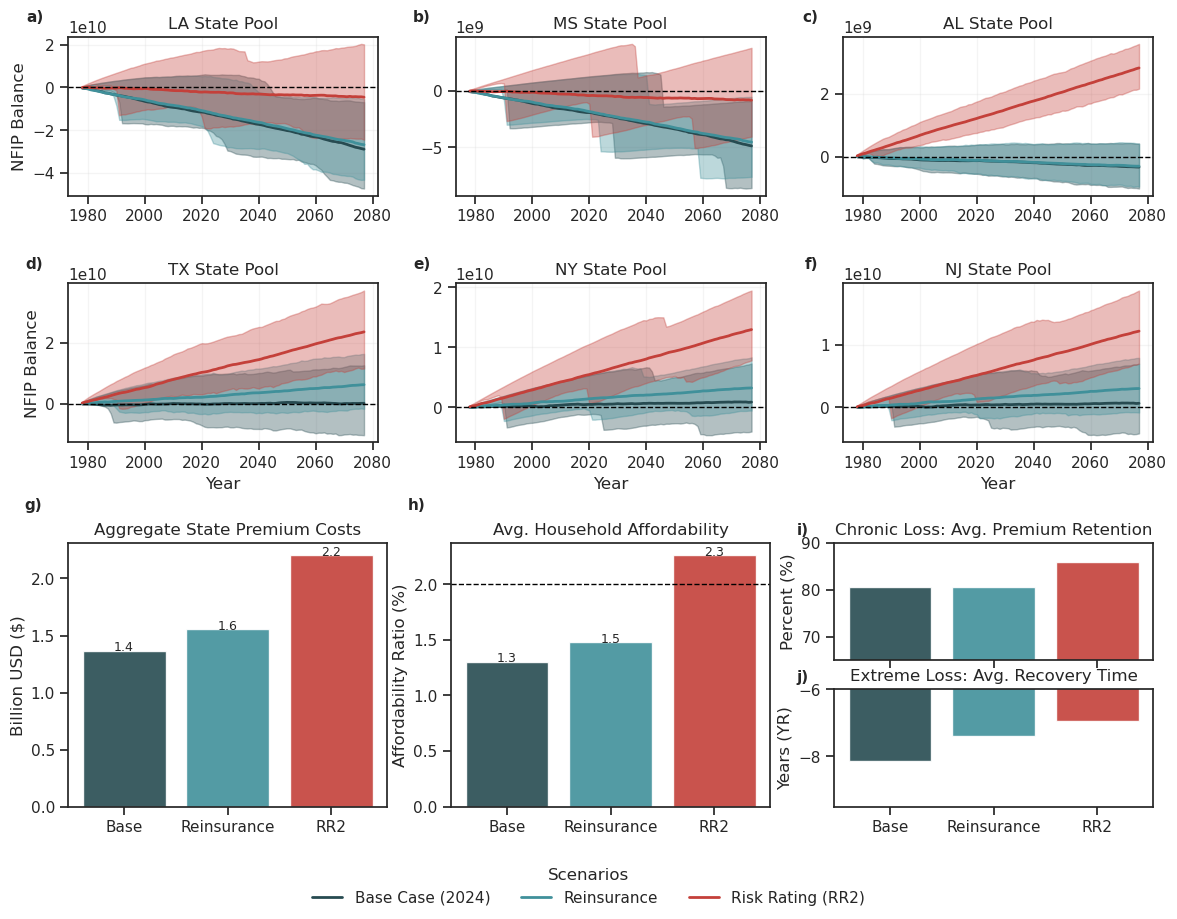

In [25]:
sns.set_theme(style="ticks")

scenario_dfs = {
    "Base Case (2024)": state_balance_df1,
    "Reinsurance": state_balance_df2,
    "Risk Rating (RR2)": state_balance_df3,
}

scenario_colors = {
    "Base Case (2024)": "#274B51", #554348
    "Reinsurance": "#40909A",
    "Risk Rating (RR2)": "#C4403A", 
}

stats_by_scenario = {
    scen_name: prep_state_stats(df, selected_states, state_abbrev)
    for scen_name, df in scenario_dfs.items()
}

# -----------------------------
# Compute aggregate summaries
# -----------------------------
agg_cost = {
    "Base": df["premium_2"].sum() / 1e9,
    "Reinsurance": (df["premium_2"].sum() / 1e9) + df["rein_increase"].sum()/1000,
    "RR2": (df["premium_2"].sum() / 1e9) + df["RR2_increase"].sum()/1000,
}

agg_afford = {
    "Base": df["base_afford"].mean(),
    "Reinsurance": df["rein_afford"].mean(),
    "RR2": df["RR2_afford"].mean(),
}

agg_chronic = {  # Avg_Pos (Chronic)
    "Base": df["Avg_Pos_1"].mean(),
    "Reinsurance": df["Avg_Pos_2"].mean(),
    "RR2": df["Avg_Pos_3"].mean(),
}

agg_extreme = {  # Avg_Neg (Extreme)
    "Base": df["Avg_Neg_1"].mean(),
    "Reinsurance": df["Avg_Neg_2"].mean(),
    "RR2": df["Avg_Neg_3"].mean(),
}

# -----------------------------
# Figure layout
# -----------------------------
n_states = len(selected_states)
n_cols = 3
n_rows = -(-n_states // n_cols)

fig = plt.figure(figsize=(14, 10))
gs = GridSpec(nrows=2, ncols=1, height_ratios=[n_rows, 1.3], hspace=0.3)

# ─────────────────────────────
# Top: Line plots by state
# ─────────────────────────────
gs_top = GridSpecFromSubplotSpec(nrows=n_rows, ncols=n_cols, subplot_spec=gs[0], wspace=0.25, hspace=0.55)

for i, state in enumerate(selected_states):
    r, c = divmod(i, n_cols)
    ax = fig.add_subplot(gs_top[r, c])

    for scen_name, stats in stats_by_scenario.items():
        color = scenario_colors.get(scen_name, "C0")
        df_sub = stats[stats["State"] == state].sort_values("year")
        if df_sub.empty:
            continue
        years = df_sub["year"].values

        # IQR shading
        ax.fill_between(years, df_sub["q25"], df_sub["q75"], color=color, alpha=0.35)
        # Mean line
        ax.plot(years, df_sub["mean"], color=color, lw=2.0, label=scen_name)

    ax.axhline(0, color="black", linestyle="--", lw=1)
    ax.set_title(f"{state} State Pool")
    ax.grid(alpha=0.2)
    if r == n_rows - 1:
        ax.set_xlabel("Year")
    if c == 0:
        ax.set_ylabel("NFIP Balance")

# Shared legend
handles = [plt.Line2D([], [], color=color, lw=2, label=name) for name, color in scenario_colors.items()]
fig.legend(handles=handles, loc="lower center", ncol=3, frameon=False, title="Scenarios")

# ─────────────────────────────
# Bottom: Aggregate barplots
# ─────────────────────────────
gs_bot = GridSpecFromSubplotSpec(nrows=1, ncols=3, subplot_spec=gs[1], wspace=0.2)

# Aggregate Cost
ax_cost = fig.add_subplot(gs_bot[0, 0])
ax_cost.bar(agg_cost.keys(), agg_cost.values(), color=scenario_colors.values(), alpha=0.9)
ax_cost.set_title("Aggregate State Premium Costs")
ax_cost.set_ylabel("Billion USD ($)")
for i, v in enumerate(agg_cost.values()):
    ax_cost.text(i, v + (0.001 * max(agg_cost.values())), f"{v:.1f}", ha="center", fontsize=9)

# Aggregate Affordability
ax_aff = fig.add_subplot(gs_bot[0, 1])
ax_aff.bar(agg_afford.keys(), agg_afford.values(), color=scenario_colors.values(), alpha=0.9)
ax_aff.axhline(y=2, color='black', linestyle='--', linewidth=1)
ax_aff.set_title("Avg. Household Affordability")
ax_aff.set_ylabel("Affordability Ratio (%)")
for i, v in enumerate(agg_afford.values()):
    ax_aff.text(i, v + (0.001 * max(agg_afford.values())), f"{v:.1f}", ha="center", fontsize=9)

# Chronic & Extreme Loss
gs_loss = GridSpecFromSubplotSpec(nrows=2, ncols=1, subplot_spec=gs_bot[0, 2], hspace=0.25, height_ratios=[1, 1])

# Chronic (Avg_Pos)
ax_chronic = fig.add_subplot(gs_loss[0, 0])
ax_chronic.bar(agg_chronic.keys(), [val*100 for val in agg_chronic.values()], color=scenario_colors.values(), alpha=0.9)
ax_chronic.set_title("Chronic Loss: Avg. Premium Retention")
ax_chronic.set_ylim([65,90])
ax_chronic.set_ylabel("Percent (%)")
ax_chronic.set_xticklabels([])

# Extreme (Avg_Neg)
ax_extreme = fig.add_subplot(gs_loss[1, 0])
ax_extreme.bar(agg_extreme.keys(), agg_extreme.values(), color=scenario_colors.values(), alpha=0.9)
ax_extreme.axhline(0, color="black", lw=1)
ax_extreme.set_title("Extreme Loss: Avg. Recovery Time")
ax_extreme.set_ylim([-9.5,-6])
ax_extreme.set_ylabel("Years (YR)")

# Add subplot labels (a), b), c)... in reading order
for i, ax in enumerate(fig.axes):
    ax.text(
        -0.08, 1.17, f"{string.ascii_lowercase[i]})",
        transform=ax.transAxes,
        fontsize=11, fontweight='bold',
        va='top', ha='right'
    )

# -----------------------------
plt.tight_layout(rect=[0, 0.02, 0.96, 1])
if save:
    plt.savefig("Plots/New/Fig4_Scenarios.png", dpi=500, bbox_inches="tight")
plt.show()